In the following code, we download all the trajectory data on envirocar.org

In [1]:
import json
import os
import requests
import urllib.parse

import geopandas as gpd
from shapely.geometry import Point, shape
import gpxpy
import gpxpy.gpx
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

EPSG4326 = 'EPSG:4326' # A common CRS used for GPS [https://epsg.io/4326]

def plot_trajectory(
    trajectory, title=None, plot_trajectory_edges=False, plot_clusters=False, color_mapping=None
):
    """
    Plot trajectory points.
    Args:
        trajectory: a GeoDataFrame object which represents trajectory points.
        title: the title of the plot
    """
    # Get the bounding box
    bbox = trajectory.to_crs(EPSG4326).total_bounds

    # 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
    minx, miny, maxx, maxy = bbox

    # Download a map by specifying the bounding box, and draw the graph
    try:
        G = ox.graph.graph_from_bbox(
            maxy, miny, maxx, minx, network_type="all_private"
        )  # The order is north, south, east, west [https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_bbox]
    except (ValueError, nx.NetworkXPointlessConcept) as e:
        # TODO: Often a "ValueError: Found no graph nodes within the requested polygon" error or
        #       "NetworkXPointlessConcept: Connectivity is undefined for the null graph" error happens.
        #       This should be fixed if possible.
        print(e)
        return
    fig, ax = ox.plot_graph(G, figsize=(16, 16), show=False, close=False) # Switch the colors for the roads and the background

    # Set the title of ax
    ax.set_title(title)
    
    geographic_gdf = trajectory.to_crs(EPSG4326)
    
    # print('trajectory[\'geometry\']\n', trajectory[trajectory['cluster'] == 1])
    # print('geographic_gdf[\'geometry\']\n', geographic_gdf[trajectory['cluster'] == 1])

    if plot_trajectory_edges:
        # Plot the trajectory edges
        tripdata_edges = mm_utils.point_to_traj(
            geographic_gdf, columns={"ele": "average", "timestamp": "first", "sat": "first"}
        )
        tripdata_edges.plot(ax=ax, linewidth=1.5)

    if plot_clusters:
        # Get unique cluster labels
        unique_labels = geographic_gdf["cluster"].unique()

        # Generate a random color for each unique cluster label
        if color_mapping is None:
            color_mapping = {
                label: "#" + "%06x" % random.randint(0, 0xFFFFFF) for label in unique_labels
            }
        
        # print(color_mapping)
        
        # Color the noises by orange
        if -1 in unique_labels:
            color_mapping[-1] = "red"

        for cluster_label in unique_labels:
            cluster_points = geographic_gdf[geographic_gdf["cluster"] == cluster_label]
            color = color_mapping[cluster_label]
            cluster_points.plot(
                ax=ax, color=color, label=f"Cluster {cluster_label}"
            )
    else:
        # Plot the trajectory points
        geographic_gdf.plot(ax=ax, color="red")

    # Draw the whole plot in the campus!
    campus = ox.features.features_from_place("Somewhere", tags={"name": True})
    campus.plot(ax=ax, alpha=0.5)
    plt.legend()
    plt.show()

def read_file_content(file_path):
    with open(file_path, "r") as file:
        content = file.read()
    return content

def GPX_to_GeoDataFrame(gpx):
    """
    Convert GPX into GeoDataFrame

    Args:
        gpx: GPX data

    Returns:
        GeoDataFrame: A GeoDataFrame of the GPX data
    """

    data = {"geometry": [], "time": [], "elevation": []}
    for segment in gpx.tracks[0].segments:
        for p in segment.points:
            data["geometry"].append(Point(p.longitude, p.latitude))
            data["time"].append(p.time)
            data["elevation"].append(p.elevation)
    return gpd.GeoDataFrame(data=data, geometry="geometry", crs=EPSG4326) # EPSG:4326 is the commonly used CRS for GPS [https://epsg.io/4326]

def to_utm_gdf(gdf):
    utm_crs = gdf.estimate_utm_crs()
    # print('utm_crs: ', utm_crs)
    utm_gdf = gdf.to_crs(crs=utm_crs)
    utm_gdf['lat_lon']  = gdf['geometry']
    return utm_gdf

def download_from_envirocar(id):
    """
    Download trajectory data from envirocar.org.

    Args:
        id: a id of dataset on envirocar.org

    Returns:
        GeoDataFrame: trajectory data
    """
    
    cache_dir = "cache/envirocar"
    cache_path = os.path.join(cache_dir, f"envirocar-{id}.geojson")
    if os.path.isfile(cache_path):
        gdf = gpd.read_file(cache_path)
        if len(gdf) <= 10:
            return None
        return to_utm_gdf(gdf)
    
    # Download trajectory data from envirocar.org.
    url = urllib.parse.urljoin('https://envirocar.org/api/stable/tracks/', id)
    response = requests.get(url)
    data = json.loads(response.text)

    # Convert the data into a GeoDataFrame
    geometries = []
    attributes = []
    for feature in data["features"]:
        geometry = shape(feature["geometry"])
        geometries.append(geometry)
        attributes.append(feature["properties"])
    
    gdf = gpd.GeoDataFrame(data=attributes, geometry=geometries)
    gdf = gdf.set_crs(EPSG4326)
    # Save to the file. It may be better to specify parameters when saving. The official doc is here: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_file.html
    gdf.to_file(cache_path)
    if len(gdf) <= 10:
        return None
    return to_utm_gdf(gdf)

def all_ids_on_envirocar():
    # Currently only downloads 100 tracks
    url = 'https://envirocar.org/api/stable/tracks/'
    response = requests.get(url)
    data = json.loads(response.text)
    ids = []
    for track in data['tracks']:
        ids.append(track['id'])
    return ids
    
ids = all_ids_on_envirocar()
print(len(ids))
print(ids)

# Download trajectory data from envirocar
# for id in ids:
#     gdf = download_from_envirocar(id)
#     print('id', id)
    # plot_trajectory(gdf, title=id)

100
['64c01ce1c7e42807e7b49a74', '64c01a72c7e42807e7b497de', '64bfe45ac7e42807e7b4216b', '64bfe410c7e42807e7b42101', '64c0036cc7e42807e7b491cf', '64bfde0ac7e42807e7b41e30', '64c0036dc7e42807e7b492b4', '64bfcb26c7e42807e7b41933', '64bfc9edc7e42807e7b416d4', '64bfc0e8c7e42807e7b414e7', '64bfbc00c7e42807e7b409c6', '64bfb97cc7e42807e7b40785', '64bfb61cc7e42807e7b3ffdd', '64bfa89bc7e42807e7b3e052', '64bf8fd2c7e42807e7b3dd47', '64bf8d2fc7e42807e7b3d853', '64bf8ad0c7e42807e7b3d4c5', '64bf88eac7e42807e7b3ceff', '64bf88b6c7e42807e7b3ced2', '64bf805fc7e42807e7b3af09', '64bf79b0c7e42807e7b3aab7', '64bf5c14c7e42807e7b2de07', '64bf59d6c7e42807e7b2dc09', '64bfa917c7e42807e7b3e170', '64bf483fc7e42807e7b2d61b', '64bfaa9cc7e42807e7b3edcf', '64bf4802c7e42807e7b2d5d3', '64bf474fc7e42807e7b2d511', '64bf46d8c7e42807e7b2d44f', '64bec4d0c7e42807e7b24374', '64bf69eac7e42807e7b310e6', '64bebd52c7e42807e7b240c3', '64be9d49c7e42807e7b1ffae', '64be9aecc7e42807e7b1f904', '64be9878c7e42807e7b1f612', '64be963fc7e428

In [2]:
# import preprocessing.dbscan

import random
import sys
import math

# # When you want to stack traces of warnings, uncomment the following two lines so that they are treated as errors.
# import warnings
# warnings.simplefilter("error")

import pandas as pd
import pyproj
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

# sys.path.append("..")
from algorithms import mm_utils

def adjust_scale(x, r):
    return np.array(x) * r

def rotate_point(x_coords, y_coords, angle_degrees, origin=(0, 0)):
    """
    Rotate a point (or list of points) around the origin (or specified point) in a 2D plane.

    Parameters:
        x_coords (list or numpy.ndarray): List of x-coordinates of the points.
        y_coords (list or numpy.ndarray): List of y-coordinates of the points.
        angle_degrees (float): Angle of rotation in degrees.
        origin (tuple, optional): Origin point (default is (0, 0)).

    Returns:
        tuple or numpy.ndarray: Tuple or array of rotated (x, y) coordinates.
    """
    angle_radians = np.radians(angle_degrees)
    cos_theta = np.cos(angle_radians)
    sin_theta = np.sin(angle_radians)
    
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)

    # Shift the coordinates to the origin
    x_coords_shifted = x_coords - origin[0]
    y_coords_shifted = y_coords - origin[1]

    # Perform rotation
    x_rotated = cos_theta * x_coords_shifted - sin_theta * y_coords_shifted
    y_rotated = sin_theta * x_coords_shifted + cos_theta * y_coords_shifted

    # Shift the coordinates back to the original position
    x_rotated += origin[0]
    y_rotated += origin[1]

    return x_rotated, y_rotated

def to_points(trajectory):
    """
    Convert trajectory points into a vector (I have to check the type) of points

    Args:
        trajectory: a GeoDataFrame represents trajectory points

    Returns:
        pandas.core.series.Series: a series of points representing trajectory points
    """
    return trajectory["geometry"].apply(lambda point: [point.x, point.y])

def knn_distance(gdf, point_index, k):
    # Calculate kNN distance
    point = gdf.geometry.iloc[point_index]
    return gdf.geometry.distance(point).sort_values().iloc[k]

def knn_distances(gdf, k):
    # Compute the points for the k-NN distance plot
    knn_distances = []
    for i in range(len(gdf)):
        knn_distances.append(knn_distance(gdf, i, k))
    return sorted(knn_distances)

def plot_skewed(x, y, W, H, degree):
    skewed_x, skewed_y = skew(x, y, W, H)
    plt.scatter(skewed_x, skewed_y, label="Skewed sorted K-NN distances", color="cyan")
    plt.title("Skewed sorted K-NN distances")
    draw_polynomial_fitting(skewed_x, skewed_y, degree)
    draw_local_minimals(skewed_x, skewed_y, degree)
    plt.show()

def DBSCAN_eps_candidates(gdf, slope, k=3, degree=9, sorted_knn_distances=None):
    if sorted_knn_distances is None:
        sorted_knn_distances = knn_distances(gdf, k)
    x = range(len(sorted_knn_distances))

    # Find the "elbows" in the skewed graph
    minimals_x, minimals_y = skewed_minimals(
        x, sorted_knn_distances, len(x), max(sorted_knn_distances), degree, slope
    )
    
    return sorted(minimals_y)

def plot_elbow_detection(gdf, slope, k=3, degree=9):
    sorted_knn_distances = knn_distances(gdf, k)
    x = range(len(sorted_knn_distances))
    
    # Find the "elbows" in the skewed graph
    minimals_x, minimals_y = skewed_minimals(
        x, sorted_knn_distances, len(x), max(sorted_knn_distances), degree, slope
    )
    
    plt.clf()
    plt.cla()
    
    # Plot the original data
    plt.scatter(x, sorted_knn_distances, label="Sorted K-NN distances")
    plt.xlabel("Sorted indexes")
    plt.ylabel("K-NN distance")
    plt.title(
        "Plot of pairs of (index, K-NN distance) by the ascending order of K-NN distance"
    )
    plt.grid(True)
    draw_polynomial_fitting(
        x, sorted_knn_distances, degree
    )  # Draw the polynomial fitting for the original data
    plt.scatter(
        minimals_x,
        minimals_y,
        s=40,
        color="Magenta",
        label="Elbows obtained by the polyfit for the skewed data",
    )
    plt.legend()
    plt.show()

def skew(x, y, x_scale, y_scale, slope):
    if x_scale < y_scale:
        x = adjust_scale(x, y_scale / x_scale)
    else:
        y = adjust_scale(y, x_scale / y_scale)
    return rotate_point(x, y, -slope)


def inv_skew(x, y, x_scale, y_scale, slope):
    x, y = rotate_point(x, y, slope)
    if x_scale < y_scale:
        x = adjust_scale(x, x_scale / y_scale)
    else:
        y = adjust_scale(y, y_scale / x_scale)
    return x, y


def draw_polynomial_fitting(x, y, degree):
    # Perform polynomial fitting
    coefficients = np.polyfit(x, y, degree)

    # Generate fitted polynomial curve
    y_fit = np.polyval(coefficients, x)
    plt.plot(x, y_fit, color="red", label=f"Polynomial Fitted Curve. degree = {degree}")


def draw_local_minimals(x, y, degree):
    # Perform polynomial fitting
    coefficients = np.polyfit(x, y, degree)

    # Find the local minimal_s
    min_x = np.min(x)
    max_x = np.max(x)
    local_minimal_x, local_minimal_y = local_minimals(coefficients, min_x, max_x)
    
    print('local_minimal_x', local_minimal_x)
    print('local_minimal_y', local_minimal_y)
    
    # Plot
    plt.scatter(
        local_minimal_x,
        local_minimal_y,
        color="Magenta",
        label=f"Local Minimals. degree = {degree}",
    )


def local_minimals(coefficients, min_x, max_x):
    # Calculate the first derivative of the polynomial
    derivative = np.polyder(coefficients, 1)

    # Find the local minimal points
    roots = [root.real for root in np.roots(derivative) if np.isreal(root)]

    # Find the local minimum points which are inside the domain
    local_minimal_x = [
        x
        for x in roots
        if np.polyval(derivative, x - 1e-5) < 0
        and np.polyval(derivative, x + 1e-5) > 0
        and min_x <= x
        and x <= max_x
    ]
    local_minimal_y = np.polyval(coefficients, local_minimal_x)
    return (local_minimal_x, local_minimal_y)


def skewed_minimals(x, y, W, H, degree, slope):
    # Skew the data points
    skewed_x, skewed_y = skew(x, y, W, H, slope)

    # Perform polynomial fitting for the skewed pairs
    coefficients = np.polyfit(skewed_x, skewed_y, degree)

    # Find the local minimum points of the fitting polynomial which are inside the domain of the skewed plot
    min_x = np.min(skewed_x)
    max_x = np.max(skewed_x)
    local_minimal_x, local_minimal_y = local_minimals(coefficients, min_x, max_x)

    # Extract points which are in the domain of the original plot
    original_x, original_y = inv_skew(local_minimal_x, local_minimal_y, W, H, slope)
    original_xy = [
        (xy[0], xy[1]) for xy in zip(original_x, original_y) if 0 <= xy[0] and xy[0] < W
    ]
    result_x = [xy[0] for xy in original_xy]
    result_y = [xy[1] for xy in original_xy]
    return (result_x, result_y)

# TODO: research good ways to decide eps and min_samples.
def trajectory_DBSCAN(trajectory, eps, min_samples): 
    """
    Cluster trajectory points using the DBSCAN algorithm.

    Args:
        trajectory: A GeoDataFrame represents trajectry points with a projected CRS
        eps: the radius of the circle used in the DBSCAN algorithm
        min_samples: the threhold used in the DBSCAN algorithm. If the number of points inside the eps-circle is greater than or equal to min_samples, then the ponit is marked as core point.

    Returns:
        numpy.ndarray: the result of clustering
    """
    # Create a pyproj.Geod object based on the CRS
    geod = trajectory.crs.get_geod()
    
#     def metric(p, q):
#         _, _, distance = geod.inv(p[0], p[1], q[0], q[1])
#         return distance
    
#     # Extract the coordinate information
#     # print(['trajectory', trajectory.columns.tolist()])
#     # points = to_points(trajectory).tolist()
#     points = [(p.y, p.x) for p in trajectory['lat_lon']]
#     # print(['points', points])
#     # print(['type(points)', type(points)])
    # def metric(p, q):
    #     print(p.distance(q))
    #     return p.distance(q)
    points = to_points(trajectory).tolist()
    # Calculate pairwise distances using your custom distance function
    # distances = pairwise_distances(to_points(trajectory).tolist())
    # print(['distances', distances])

    # Create a DBSCAN object with your customized distance metric
    # dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    # labels = dbscan.fit_predict(points)
    return labels

def mitigate_stay_points(gdf):
    # Find out clusters by DBSCAN
    eps_candidates = DBSCAN_eps_candidates(gdf)
    eps = eps_candidates[0]
    min_samples = 6 #4
    gdf["cluster"] = trajectory_DBSCAN(
            gdf, eps=eps, min_samples=min_samples
        )

    # Average each cluster
    def average_times(x):
        return pd.to_datetime(x).astype('int64').mean()

    # Fix this function if its perfomance is critical
    def average_points(x):
        x_mean = x.map(lambda p: p.x).mean()
        y_mean = x.map(lambda p: p.y).mean()
        return Point(x_mean, y_mean)

    excluded_gdf = gdf[gdf['cluster'] == -1]
    averaged_gdf  = gdf[gdf['cluster'] != -1].groupby('cluster').agg(
            id=('id', 'first'),
            time=('time', average_times),
            phenomenons=('phenomenons', 'first'),
            geometry=('geometry', average_points),
            lat_lon=('lat_lon', average_points),
            cluster=('cluster', 'first')
    )

    merged_df = pd.concat([averaged_gdf, excluded_gdf])
    return gpd.GeoDataFrame(data=merged_df, geometry='geometry', crs=gdf.crs)#.drop('cluster', axis=1)

def eliminate_outliers(gdf, slope, min_samples):
    # Find out clusters by DBSCAN
    gdf = gdf.copy()
    
    # Minimum value for eps
    # min_samples = 3 #4
    max_outlier_rate = 0.05
    sorted_knn_distances = knn_distances(gdf, min_samples)
    min_eps = sorted_knn_distances[math.ceil(len(gdf) * (1 - max_outlier_rate) - 1)]
    
    # Finding eps candidates by the elbow method
    eps_candidates = DBSCAN_eps_candidates(gdf, slope, sorted_knn_distances=sorted_knn_distances)
    eps = max(eps_candidates[-1], min_eps) if len(eps_candidates) > 0 else min_eps
    # if len(eps_candidates) == 0:
    #     gdf['cluster'] = -1
    #     return gdf
    
    # Decide the eps by taking minimum
    # eps = max(eps_candidates[-1], min_eps)
    
    # Eliminating outliers by DBSCAN
    gdf["cluster"] = trajectory_DBSCAN(
            gdf, eps=eps, min_samples=min_samples
        )
    return gdf[gdf['cluster'] != -1]

In [3]:
def mean_interval_between_adjacent_points(gdf):
    """
    Compute the mean of intervals between two adjacent points in a GeoDataFrame.

    Parameters:
        gdf (geopandas.GeoDataFrame): The input GeoDataFrame.

    Returns:
        float: Mean interval between adjacent points.
    """
    # Shift the geometry column to get the next point's geometry
    gdf['next_geometry'] = gdf['geometry'].shift(-1)

    # Compute the distance between each point and the next point
    gdf['distance'] = gdf['geometry'].distance(gdf['next_geometry'])

    # Compute the mean of the distances
    mean_distance = gdf['distance'].mean()

    # Remove the temporary columns
    gdf.drop(columns=['next_geometry', 'distance'], inplace=True)

    return mean_distance

def make_noise(mean, std_dev, magnitude, min_noise):
    while True:
        noise = np.random.normal(loc=mean, scale=std_dev) * magnitude
        if noise >= min_noise:
            return noise

def perturbate_selected_rows(gdf, perturbation_percentage=0.05, mean=0, std_dev=1, label_column='label'):
    """
    Perturbate selected rows in a GeoDataFrame.

    Parameters:
        gdf (geopandas.GeoDataFrame): The input GeoDataFrame.
        perturbation_percentage (float): The percentage of rows to perturbate.
        mean (float): Mean of the normal distribution for perturbation.
        std_dev (float): Standard deviation of the normal distribution for perturbation.
        label_column (str): The column name that contains the label (1 for selected, 0 for not selected).

    Returns:
        geopandas.GeoDataFrame: A new GeoDataFrame with perturbated selected rows.
    """
    #gdf = gdf.copy()
    # Step 1: Calculate the number of rows to randomly pick
    num_rows_to_pick = int(len(gdf) * perturbation_percentage)
    
    # print('# of selected points: ', num_rows_to_pick)

    # Step 2: Randomly select the subset of rows
    random_subset = gdf.sample(n=num_rows_to_pick, random_state=42)

    # Step 3: Add labels to the randomly selected rows
    # For the selected rows, set the label to 1; otherwise, set it to 0
    gdf[label_column] = np.where(gdf.index.isin(random_subset.index), 1, 0)

    # Step 4: Perturbate only the selected rows
    selected_rows = gdf[gdf[label_column] == 1].copy()  # Make a copy to avoid SettingWithCopyWarning
    mean_interval = mean_interval_between_adjacent_points(gdf)
    # I'm not sure if these parameters are ok
    noise_magnitude = mean_interval * 6
    min_noise = mean_interval * 2
    
    # Loop through each selected point and apply noise
    for _, row in selected_rows.iterrows():
        # Generate noise with minimum standard deviation
        noise_x = make_noise(mean, std_dev, noise_magnitude, min_noise)
        noise_y = make_noise(mean, std_dev, noise_magnitude, min_noise)
        
        # Apply noise to the point
        row['geometry'] = Point(row['geometry'].x + noise_x, row['geometry'].y + noise_y)
        
        # Update the modified row back to the DataFrame
        selected_rows.at[_, 'geometry'] = row['geometry']
    
    # Create a new GeoDataFrame by combining perturbated selected rows with unselected rows
    perturbated_gdf = pd.concat([selected_rows, gdf[gdf[label_column] == 0]])

    # Return the new GeoDataFrame with perturbated selected rows
    return gpd.GeoDataFrame(perturbated_gdf, geometry='geometry')

valid_ids = []
perturbated_gdfs = []

for id in ids:
        gdf = download_from_envirocar(id)

        if gdf is None:
            continue
        
        perturbated_gdf = perturbate_selected_rows(gdf, perturbation_percentage=0.05, mean=0, std_dev=1, label_column = 'noise')
        valid_ids.append(id)
        perturbated_gdfs.append(perturbated_gdf)
print(len(valid_ids))

92


In [4]:
from tqdm.notebook import tqdm
import dask
import dask.bag as db

import warnings
warnings.simplefilter("error")

def empty_gdf():
    # Create an empty DataFrame
    empty_df = pd.DataFrame()

    # Add a geometry column to the DataFrame (can be any name you prefer)
    geometry_column_name = 'geometry'
    empty_df[geometry_column_name] = None
    return gpd.GeoDataFrame(empty_df, geometry=geometry_column_name)

def sigle_outlier_detection_experiment(slope, id, perturbated_gdf):
    # perturbated_gdf = perturbate_selected_rows(gdf, perturbation_percentage=0.05, mean=0, std_dev=1, label_column = 'noise')
    eliminated_gdf = eliminate_outliers(perturbated_gdf, slope, min_samples=3).drop('cluster', axis=1)

    # Perform the spatial difference overlay operation
    difference_gdf = perturbated_gdf.overlay(eliminated_gdf, how='difference')
    eliminated_outliers_gdf = difference_gdf[difference_gdf['noise'] == 1]
    eliminated_nonoutliers_gdf = difference_gdf[difference_gdf['noise'] == 0]
    
    return (slope, id, len(perturbated_gdf[perturbated_gdf['noise'] == 1]), len(eliminated_outliers_gdf), len(perturbated_gdf[perturbated_gdf['noise'] == 0]), len(eliminated_nonoutliers_gdf))

fineness = 10 #900
num_trajectories = len(valid_ids)

total_outliers = np.zeros((fineness, num_trajectories))
eliminated_outliers = np.zeros((fineness, num_trajectories))
nonoutliers = np.zeros((fineness, num_trajectories))
eliminated_nonoutliers = np.zeros((fineness, num_trajectories))
done_ids = np.full((fineness, num_trajectories), '')

outlier_detection_results = []

for i in tqdm(range(0, fineness)):
    # print(['i', i])
    slope = 90 * i / fineness
    for j in range(num_trajectories):
        id = valid_ids[j]
        perturbated_gdf = perturbated_gdfs[j]
        outlier_detection_results.append(dask.delayed(sigle_outlier_detection_experiment)(slope, id, perturbated_gdf))

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    outlier_detection_results = dask.compute(*outlier_detection_results, scheduler='processes')

[####################################### ] | 99% Completed | 44.10 ss

Exception ignored in: <function Socket.__del__ at 0x7f39251e98a0>
Traceback (most recent call last):
  File "/home/atsuro/anaconda3/envs/mitsubishi-2022/lib/python3.11/site-packages/zmq/sugar/socket.py", line 182, in __del__
    warn(


[########################################] | 100% Completed | 44.20 s


In [6]:
slope_to_index = {}
for i in tqdm(range(0, fineness)):
    slope = 90 * i / fineness
    slope_to_index[slope] = i

id_to_index = {}
for i, id in enumerate(valid_ids):
    id_to_index[id] = i

total_outliers = np.zeros((fineness, num_trajectories))
eliminated_outliers = np.zeros((fineness, num_trajectories))
total_nonoutliers = np.zeros((fineness, num_trajectories))
eliminated_nonoutliers = np.zeros((fineness, num_trajectories))
done_ids = np.full((fineness, num_trajectories), '')

for outlier_detection_result in outlier_detection_results:
    slope, id, num_total_outliers, num_eliminated_outliers, num_total_nonoutliers, num_eliminated_nonoutliers = outlier_detection_result
    
    i = slope_to_index[slope]
    j = id_to_index[id]
    total_outliers[i, j] = num_total_outliers
    eliminated_outliers[i, j] = num_eliminated_outliers
    total_nonoutliers[i, j] = num_total_nonoutliers
    eliminated_nonoutliers[i, j] = num_eliminated_nonoutliers
    done_ids[i, j] = valid_ids[j]

  0%|          | 0/10 [00:00<?, ?it/s]

In the following code, we download GPS traces from Open Street Map, cluster it by using the DBSCAN algorithm, and then plot the result.

  0%|          | 0/10 [00:00<?, ?it/s]

[14.  2. 10.  9.  2. 12.  5.  5.  1.  2. 11.  2. 11.  6.  2.  8.  4.  1.
  9. 11. 16. 12.  7. 15.  8.  8.  0.  1.  1.  8.  1. 14.  3. 13. 16. 14.
 17.  0.  0. 19. 17. 11. 17.  4. 11. 20.  0.  2.  7.  2.  1. 10. 16. 11.
 23. 11.  3.  5.  6. 12.  8. 57. 23. 40.  2. 34.  4.  9. 14.  5.  2. 26.
  3.  4.  2.  0.  1.  2. 18. 18.  5.  1.  3. 30.  6. 11.  1. 13. 15.  0.
 23. 18.]
[14.  2. 10.  9.  2. 12.  5.  5.  1.  2. 11.  2. 11.  6.  2.  8.  4.  1.
  9. 11. 16. 12.  7. 15.  8.  8.  0.  1.  1.  8.  1. 14.  3. 13. 16. 14.
 17.  0.  0. 19. 17. 11. 17.  4. 11. 20.  0.  2.  7.  2.  1. 10. 16. 11.
 23. 11.  3.  5.  6. 12.  8. 57. 23. 40.  2. 34.  4.  9. 14.  5.  2. 26.
  3.  4.  2.  0.  1.  2. 18. 18.  5.  1.  3. 30.  6. 11.  1. 13. 15.  0.
 23. 18.]
[14.  2. 10.  9.  2. 12.  5.  5.  1.  2. 11.  2. 11.  6.  2.  8.  4.  1.
  9. 11. 16. 12.  7. 15.  8.  8.  0.  1.  1.  8.  1. 14.  3. 13. 16. 14.
 17.  0.  0. 19. 17. 11. 17.  4. 11. 20.  0.  2.  7.  2.  1. 10. 16. 11.
 23. 11.  3.  5.  6. 12.  8. 57

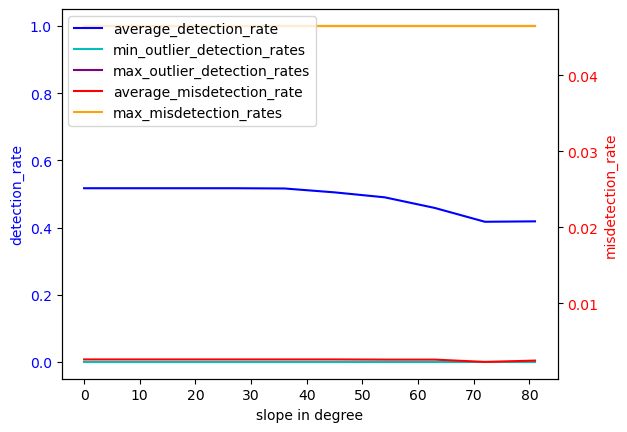

[0.5169482226831025, 0.5169482226831025, 0.5169482226831025, 0.5169482226831025, 0.5161829946451473, 0.5046282440873968, 0.4898916798625109, 0.4582394203842119, 0.4171243481173384, 0.4183823434989113]
[0.0026201907342234955, 0.0026201907342234955, 0.0026201907342234955, 0.0026201907342234955, 0.0026201907342234955, 0.0026201907342234955, 0.0025954871769112427, 0.0025954871769112427, 0.0022920339346943082, 0.002467900809534429]
[0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744, 0.046511627906976744]


In [7]:
def average_outlier_detection_rate(total_outliers, detected_outliers):
    sum_outlier_detection_rate = 0
    counter = 0
    for i in range(len(total_outliers)):
        if total_outliers[i] > 0:
            sum_outlier_detection_rate += detected_outliers[i] / total_outliers[i]
            counter += 1
    if counter == 0:
        return -1
    print(detected_outliers)
    return sum_outlier_detection_rate / counter

def max_detection_rate(total_outliers, detected_outliers):
    result = 0
    for i in range(len(total_outliers)):
        if total_outliers[i] > 0:
            result = max(result, detected_outliers[i] / total_outliers[i])
    return result

def min_detection_rate(total_outliers, detected_outliers):
    result = 1
    for i in range(len(total_outliers)):
        if total_outliers[i] > 0:
            result = min(result, detected_outliers[i] / total_outliers[i])
    return result

def average_misdetection_rate(total_nonoutliers, misdetected_nonoutliers):
    sum_misdetected_nonoutliers_rate = 0
    counter = 0
    for i in range(len(total_nonoutliers)):
        if total_nonoutliers[i] > 0:
            sum_misdetected_nonoutliers_rate += misdetected_nonoutliers[i] / total_nonoutliers[i]
            counter += 1
    if counter == 0:
        return -1
    return sum_misdetected_nonoutliers_rate / counter

def max_misdetection_rate(total_nonoutliers, misdetected_nonoutliers):
    result = 0
    for i in range(len(total_nonoutliers)):
        if total_nonoutliers[i] > 0:
            result = max(result, misdetected_nonoutliers[i] / total_nonoutliers[i])
    return result

detection_rates_x = []
detection_rates_y = []
max_outlier_detection_rates_x = []
max_outlier_detection_rates_y = []
min_outlier_detection_rates_x = []
min_outlier_detection_rates_y = []
misdetection_rates_x = []
misdetection_rates_y = []
max_misdetection_rates_x = []
max_misdetection_rates_y = []

for i in tqdm(range(0, fineness)):
    slope = 90 * i / fineness
    detection_rate = average_outlier_detection_rate(total_outliers[i], eliminated_outliers[i])
    if detection_rate != -1:
        detection_rates_x.append(slope)
        detection_rates_y.append(detection_rate)
        min_outlier_detection_rates_x.append(slope)
        min_outlier_detection_rates_y.append(min_detection_rate(total_outliers[i], eliminated_outliers[i]))
        max_outlier_detection_rates_x.append(slope)
        max_outlier_detection_rates_y.append(max_detection_rate(total_outliers[i], eliminated_outliers[i]))
    
    misdetection_rate = average_misdetection_rate(total_nonoutliers[i], eliminated_nonoutliers[i])
    if misdetection_rate != -1:
        misdetection_rates_x.append(slope)
        misdetection_rates_y.append(misdetection_rate)
        max_misdetection_rates_x.append(slope)
        max_misdetection_rates_y.append(max_misdetection_rate(total_nonoutliers[i], eliminated_nonoutliers[i]))
# Create a new figure
fig, ax1 = plt.subplots()

# Plot the first list with its own Y-axis
ax1.plot(detection_rates_x, detection_rates_y, color='b', label='average_detection_rate')
ax1.plot(min_outlier_detection_rates_x, min_outlier_detection_rates_y, color='c', label='min_outlier_detection_rates')
ax1.plot(max_outlier_detection_rates_x, max_outlier_detection_rates_y, color='purple', label='max_outlier_detection_rates')
ax1.set_xlabel('slope in degree')
ax1.set_ylabel('detection_rate', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary Y-axis for the second list
ax2 = ax1.twinx()

# Plot the second list with its own Y-axis
plt.plot(misdetection_rates_x, misdetection_rates_y, color='r', label='average_misdetection_rate')
plt.plot(max_misdetection_rates_x, max_misdetection_rates_y, color='orange', label='max_misdetection_rates')
ax2.set_ylabel('misdetection_rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends for both lists
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()
print(detection_rates_y)
print(misdetection_rates_y)
print(max_misdetection_rates_y)

In the following code, we download trajectory data from envirocar.org and plot it with its trajectory graph.